<a href="https://colab.research.google.com/github/nraptisss/Hate-Speech-Detection-using-Neural-Networks/blob/main/Diplw_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U imbalanced-learn
!pip install transformers
!pip install datasets
!pip install torch --upgrade
!pip install transformers --upgrade

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow_io')
import logging
import time
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import spacy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from torch.optim import AdamW, RAdam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification, get_linear_schedule_with_warmup, logging as hf_logging
import nltk
nltk.download('stopwords')
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from collections import Counter

# Configure logging level to suppress warnings from transformers library
logging.basicConfig(level=logging.ERROR)
hf_logging.set_verbosity_error()

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 256

# Load the Davidson and ethos dataset
df_davidson = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
ethos_data = load_dataset('ethos', 'binary')
ethos_df = ethos_data['train'].to_pandas()

# Load the HateXplain dataset from Hugging Face
hatexplain_data = load_dataset('hatexplain')
hatexplain_df = hatexplain_data['train'].to_pandas()

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Load the OLID dataset
olid_train_df = pd.read_csv('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt', sep='\t', header=None, names=['tweet'])
olid_train_labels = pd.read_csv('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt', sep='\t', header=None, names=['class'])
olid_train_df = pd.concat([olid_train_df, olid_train_labels], axis=1)

# Load the additional hate speech dataset
additional_dataset_url = "https://raw.githubusercontent.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset/main/Dynamically%20Generated%20Hate%20Dataset%20v0.2.3.csv"
additional_dataset = pd.read_csv(additional_dataset_url)

stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    """
    Preprocess text data by removing URLs, mentions, hashtags,
    and punctuation, and applying lemmatization.
    """
    # Lowercase the text
    text = text.lower()

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)

    # Apply lemmatization
    doc = nlp(text)
    words = [token.lemma_ for token in doc]

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    text = ' '.join(words)

    return text

# Combine the 'Hate Speech' and 'Offensive Language' classes in Davidson dataset by taking majority vote among annotators for each post.
label_map = {0: 0, 1: 0, 2: 1}
df_davidson['class'] = df_davidson['class'].map(label_map)

# Preprocess the text data using the preprocess_text function in Davidson dataset.
df_davidson['tweet'] = df_davidson['tweet'].apply(preprocess_text)

# Preprocess the text data using the preprocess_text function in Ethos dataset.
ethos_df['text'] = ethos_df['text'].apply(preprocess_text)

# Preprocess the HateXplain dataset using the preprocess_text function in HateXplain dataset.
hatexplain_df['post_tokens'] = hatexplain_df['post_tokens'].apply(lambda x: ' '.join(x)).apply(preprocess_text)

# Preprocess the text data using the preprocess_text function in OLID dataset.
olid_train_df['tweet'] = olid_train_df['tweet'].apply(preprocess_text)

# Select only the "text" and "label" columns from the additional dataset
additional_dataset = additional_dataset[["text", "label"]]

# Apply the preprocess_text function to the new dataset
additional_dataset['text'] = additional_dataset['text'].apply(preprocess_text)

# Transform class labels in the new dataset: "hate" to 1 and "nothate" to 0
additional_dataset['label'] = additional_dataset['label'].map({'hate': 1, 'nothate': 0})

# Rename columns in the new dataset to match the existing datasets
additional_dataset.rename(columns={'text': 'tweet', 'label': 'class'}, inplace=True)

# Filter only the "hate" examples from the new dataset
hate_examples = additional_dataset[additional_dataset['class'] == 1]

# Combine hate speech and offensive speech labels in HateXplain dataset by taking majority vote among annotators for each post.
hatexplain_df['label'] = hatexplain_df['annotators'].apply(lambda x: int(sum(x['label']) / len(x['label']) >= 1))

# Rename columns in Ethos and HateXplain datasets
ethos_df.rename(columns={'text': 'tweet', 'label': 'class'}, inplace=True)
hatexplain_df.rename(columns={'post_tokens': 'tweet', 'label': 'class'}, inplace=True)

# Combine the Davidson, Ethos, and HateXplain datasets.
df_combined = pd.concat([
    df_davidson[['tweet', 'class']],
    ethos_df[['tweet', 'class']],
    hatexplain_df[['tweet', 'class']],
    hate_examples
], axis=0)

# Combine the OLID dataset with the existing training data
df_combined = pd.concat([df_combined, olid_train_df], axis=0)

# Drop rows with missing values.
df_combined.dropna(subset=['class'], inplace=True)

# Print the shape of the combined dataset
print(f'Combined dataset shape: {df_combined.shape}')

# Print the number of samples in each class
print('Number of samples in each class:')
print(df_combined['class'].value_counts())

# Print the first few rows of the combined dataset
print('First few rows of the combined dataset:')
print(df_combined.head())

# Print the number of missing values in each column
print('Number of missing values in each column:')
print(df_combined.isnull().sum())

# Print the length of the longest text in the combined dataset
print('Length of the longest text:')
print(df_combined['tweet'].str.len().max())

# Print the average length of the text in the combined dataset
print('Average length of the text:')
print(df_combined['tweet'].str.len().mean())

total_rows = df_davidson.shape[0] + ethos_df.shape[0] + hatexplain_df.shape[0] + olid_train_df.shape[0]
if df_combined.shape[0] == total_rows:
    print('All data is included in the final dataset.')
else:
    print('Some data is missing from the final dataset.')


# Split the combined dataset into train and validation sets.
train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['class'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights = torch.tensor(class_weights).to(device)
class_weights = class_weights.float()


# Tokenize and pad the text data using the DistilBERT tokenizer.
train_inputs = tokenizer(train_df['tweet'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
train_labels = torch.tensor(train_df['class'].values)

# # Apply SMOTE to balance the class distribution in the training data
# smote = SMOTE(random_state=42)
# train_inputs_smote, train_labels_smote = smote.fit_resample(train_inputs['input_ids'], train_labels)

# # Convert the training data to tensors
# train_inputs_smote = torch.tensor(train_inputs_smote)
# train_labels_smote = torch.tensor(train_labels_smote)

# # Convert the train_inputs_smote tensor back to a list of strings
# train_inputs_smote_list = []
# for i in range(train_inputs_smote.shape[0]):
#     train_inputs_smote_list.append(tokenizer.decode(train_inputs_smote[i]))

# Create a new attention mask tensor that matches the size of train_inputs_smote
#train_attention_mask = tokenizer(train_inputs_smote_list, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')['attention_mask']

val_inputs = tokenizer(val_df['tweet'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
val_labels = torch.tensor(val_df['class'].values)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/998 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

Combined dataset shape: (75255, 2)
Number of samples in each class:
1    40840
0    34415
Name: class, dtype: int64
First few rows of the combined dataset:
                                               tweet  class
0    rt   woman complain clean house amp man alwa...      1
1    rt   boy dat coldtyga dwn bad cuffin dat hoe...      0
2    rt   dawg rt   ever fuck bitch start cry con...      0
3                             rt    look like tranny      0
4    rt   shit hear I might true might faker bitc...      0
Number of missing values in each column:
tweet    0
class    0
dtype: int64
Length of the longest text:
1975
Average length of the text:
66.01278320377384
Some data is missing from the final dataset.


Epoch 1: 100%|██████████| 1882/1882 [02:12<00:00, 14.23it/s, Loss=0.288]


Epoch [1/5], Average Loss: 0.4549
Validation Accuracy: 0.834
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      6883
           1       0.83      0.87      0.85      8168

    accuracy                           0.83     15051
   macro avg       0.83      0.83      0.83     15051
weighted avg       0.83      0.83      0.83     15051

Validation AUC ROC: 0.909


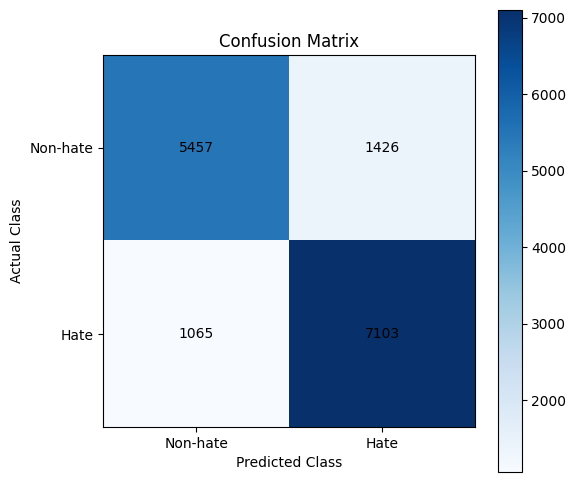

Epoch 2: 100%|██████████| 1882/1882 [02:11<00:00, 14.29it/s, Loss=0.307]


Epoch [2/5], Average Loss: 0.3620
Validation Accuracy: 0.852
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6883
           1       0.86      0.86      0.86      8168

    accuracy                           0.85     15051
   macro avg       0.85      0.85      0.85     15051
weighted avg       0.85      0.85      0.85     15051

Validation AUC ROC: 0.923


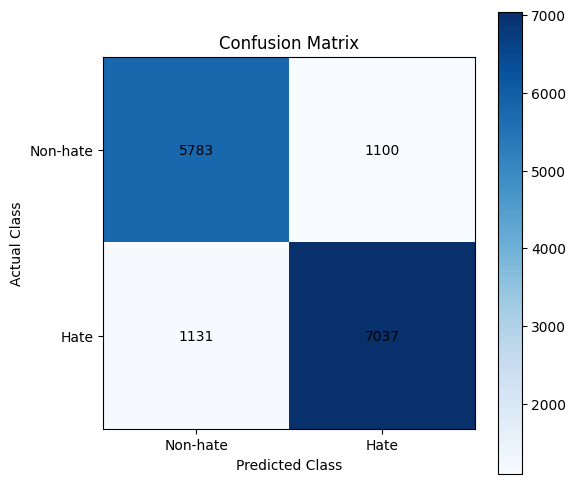

Epoch 3: 100%|██████████| 1882/1882 [02:15<00:00, 13.91it/s, Loss=0.569]


Epoch [3/5], Average Loss: 0.3244
Validation Accuracy: 0.843
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      6883
           1       0.90      0.80      0.85      8168

    accuracy                           0.84     15051
   macro avg       0.84      0.85      0.84     15051
weighted avg       0.85      0.84      0.84     15051

Validation AUC ROC: 0.928


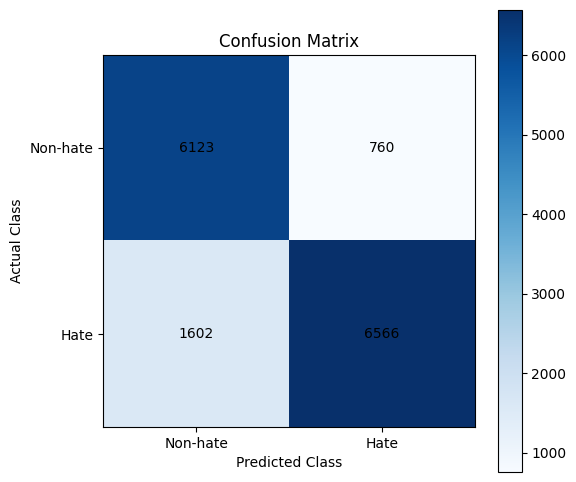

Epoch 4: 100%|██████████| 1882/1882 [02:14<00:00, 14.00it/s, Loss=0.17]


Epoch [4/5], Average Loss: 0.2924
Validation Accuracy: 0.856
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6883
           1       0.86      0.87      0.87      8168

    accuracy                           0.86     15051
   macro avg       0.86      0.85      0.86     15051
weighted avg       0.86      0.86      0.86     15051

Validation AUC ROC: 0.928


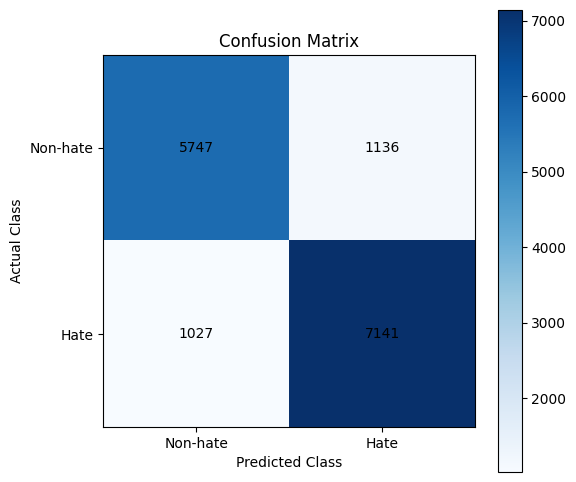

Epoch 5: 100%|██████████| 1882/1882 [02:11<00:00, 14.27it/s, Loss=0.28]


Epoch [5/5], Average Loss: 0.2628
Epoch 00005: reducing learning rate of group 0 to 5.0000e-06.
Validation Accuracy: 0.847
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      6883
           1       0.87      0.84      0.86      8168

    accuracy                           0.85     15051
   macro avg       0.85      0.85      0.85     15051
weighted avg       0.85      0.85      0.85     15051

Validation AUC ROC: 0.925


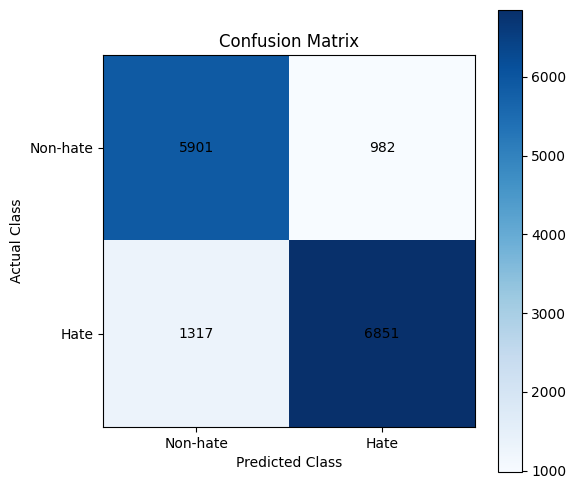

('distilbert_hate_speech_model/tokenizer_config.json',
 'distilbert_hate_speech_model/special_tokens_map.json',
 'distilbert_hate_speech_model/vocab.txt',
 'distilbert_hate_speech_model/added_tokens.json')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

import matplotlib.pyplot as plt

# Define the DistilBERT model for sequence classification
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

import gc
gc.collect()
torch.cuda.empty_cache()

# Check if GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_inputs.to(device)
train_labels.to(device)
val_inputs.to(device)
val_labels.to(device)

num_epochs = 5

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Define the gradient scaler
scaler = GradScaler()

# Define the batch size
batch_size = 32

# Define the accumulation steps
accumulation_steps = 4

# Define the maximum gradient norm
max_grad_norm = 1.0

# Create an empty list to accumulate gradients
grad_accumulator = []

# Create a DataLoader for the training data
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Create a progress bar for the current epoch
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}')

    for step, batch in enumerate(progress_bar):
        # Forward pass
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with autocast():
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.float()

            # Convert labels to long data type
            labels = labels.long()
            loss = criterion(outputs, labels)

        # Backward pass
        scaler.scale(loss).backward()

        # Accumulate gradients
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
            # Unscale the gradients
            scaler.unscale_(optimizer)

            # Clip the gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Accumulate the unscaled gradients
            grad_accumulator.append(loss.item())

            # Update the model parameters
            scaler.step(optimizer)

            # Clear the gradients
            scaler.update()
            model.zero_grad()

            # Print the average loss over accumulation steps
            avg_loss = sum(grad_accumulator) / len(grad_accumulator)
            progress_bar.set_postfix({'Loss': avg_loss})

            # Clear the gradient accumulator
            grad_accumulator = []
        else:
            # Accumulate the unscaled gradients
            grad_accumulator.append(loss.item())

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Evaluate the model on the validation set
    model.eval()

    # Create a DataLoader for the validation data
    val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    val_predictions = []
    val_probabilities = []
    val_total_loss = 0.0

    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            predictions = outputs.argmax(dim=1).cpu().numpy()
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            val_predictions.extend(predictions)
            val_probabilities.extend(probabilities)
            val_total_loss += criterion(outputs, labels).item()

    # Calculate the average validation loss
    val_average_loss = val_total_loss / len(val_dataloader)

    # Update the scheduler with the validation loss
    scheduler.step(val_average_loss)

    val_predictions = np.array(val_predictions)
    val_accuracy = (val_predictions == val_df['class'].values).mean()
    val_classification_report = classification_report(val_df['class'].values, val_predictions)

    # Calculate the AUC ROC score
    val_auc_roc = roc_auc_score(val_df['class'].values, val_probabilities)

    print(f'Validation Accuracy: {val_accuracy:.3f}')
    print('Classification Report:')
    print(val_classification_report)
    print(f'Validation AUC ROC: {val_auc_roc:.3f}')

    # Calculate the confusion matrix
    cm = confusion_matrix(val_df['class'].values, val_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.xticks([0,1], ['Non-hate', 'Hate'])
    plt.yticks([0,1], ['Non-hate', 'Hate'])
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')
    plt.show()


# Save the trained model
model.save_pretrained('distilbert_hate_speech_model')
tokenizer.save_pretrained('distilbert_hate_speech_model')